<a href="https://colab.research.google.com/github/saisatvik5/Playing-With-Ai-ML/blob/main/intel_Image_classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
 ! pip install -q kaggle

In [8]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [9]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
# Download Data
!kaggle datasets download -d 'puneet6060/intel-image-classification'

100% 346M/346M [00:02<00:00, 156MB/s]
100% 346M/346M [00:02<00:00, 156MB/s]


In [12]:
!unzip '/content/intel-image-classification'

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [13]:
import pandas as pd
import string
import numpy as np
from PIL import Image
import pathlib
import os
import glob as gb
import matplotlib.pyplot as plt
import random
import matplotlib.image as img
import tensorflow as tf
tf.__version__

'2.5.0'

In [20]:
SEED = 4

In [14]:
# See a picture in the training set
DIR = '/content/intel-image-classification'

# train, test, pred directory:
trainDIR = '/content/seg_train/seg_train'
testDIR = '/content/seg_test/seg_test'
predDIR = '/content/seg_pred/seg_pred'


print('trainDIR = Training Directory:')
print(trainDIR)
print()
print('testDIR = Test Directory:')
print(testDIR)
print()
print('predDIR = Prediction Directory:')
print(predDIR)

trainDIR = Training Directory:
/content/seg_train/seg_train

testDIR = Test Directory:
/content/seg_test/seg_test

predDIR = Prediction Directory:
/content/seg_pred/seg_pred


## See Distribution of Training and Test Data

In [15]:
# Distribution of Training Data
print('Training Data Directory:')
print(trainDIR)
print('-'*70)
for folder in os.listdir(trainDIR):
    files=gb.glob(pathname=str(trainDIR + '/' + folder +'/*.jpg'))
    print(f'{len(files):4} images are founnd in {folder} folder.')

Training Data Directory:
/content/seg_train/seg_train
----------------------------------------------------------------------
2191 images are founnd in buildings folder.
2404 images are founnd in glacier folder.
2512 images are founnd in mountain folder.
2274 images are founnd in sea folder.
2271 images are founnd in forest folder.
2382 images are founnd in street folder.


In [16]:
# Test Data
print('Test Data Directory:')
print(testDIR)
print('-'*70)
for folder in os.listdir(testDIR):
    files=gb.glob(pathname=str(testDIR + '/' + folder +'/*.jpg'))
    print(f'{len(files):4} images are founnd in {folder} folder.')

Test Data Directory:
/content/seg_test/seg_test
----------------------------------------------------------------------
 437 images are founnd in buildings folder.
 553 images are founnd in glacier folder.
 525 images are founnd in mountain folder.
 510 images are founnd in sea folder.
 474 images are founnd in forest folder.
 501 images are founnd in street folder.


In [17]:
# Prediction Data
print('Prediction Data Directory:')
print(predDIR)
print('-'*70)
files= gb.glob(pathname=str(predDIR + "/*.jpg"))
print(f"{len(files)} images are found in predict data.")

Prediction Data Directory:
/content/seg_pred/seg_pred
----------------------------------------------------------------------
7301 images are found in predict data.


# Data Preprocessing

## Resize and Define Batch Size

In [18]:
BATCH_SIZE = 16
IMG_HEIGHT = 64
IMG_WIDTH = 64

Training dataset preprocessing:

In [21]:
# Generate a tf.data.Dataset from image files in a directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=trainDIR,
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.


Test dataset preprocessing:

In [22]:
# Test dataset preprocessing
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=testDIR,
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

Found 3000 files belonging to 6 classes.


Prediction dataset preprocessing. We don't have to define the batch size in here, just resize the images.

In [24]:
# Resize the 
pred_ds = tf.keras.preprocessing.image_dataset_from_directory(
    label_mode=None,
    directory='/content/seg_pred',
    image_size=(IMG_HEIGHT, IMG_WIDTH))

Found 7301 files belonging to 1 classes.


Exam the label classes:

In [25]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## Plot a Sample of Training Image Batch

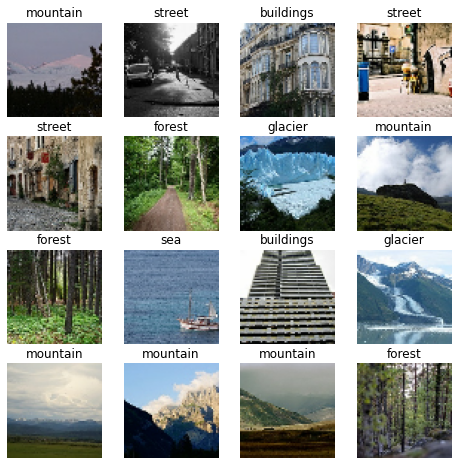

In [26]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1): 
    for i in range(BATCH_SIZE): #plot first 9 images, I did not define a batch size since the training set is already small
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

# Build a basic CNN model

In [27]:
num_classes = len(class_names) #from the given project

CNNmodel1 = tf.keras.models.Sequential([
  #first we need to rescale the images  to 0 1and 1
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, 
                                                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  
  tf.keras.layers.Conv2D(32, kernel_size=(4,4), activation='relu'),
  tf.keras.layers.MaxPooling2D(),  

  tf.keras.layers.Conv2D(64, kernel_size=(4,4), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
#  tf.keras.layers.Dropout(0.25),
    
  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(128, activation='relu'),
#  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Dense(num_classes)
])

In [28]:
# Compile the model
CNNmodel1.compile(optimizer="adam",
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])

In [ ]:
# Train the model:
ES=tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

CNNhistory1 = CNNmodel1.fit(train_ds,
                            validation_data=test_ds,
                            epochs=20,
                            verbose=1,
                            callbacks = [ES])

Epoch 1/20
878/878 [==============================] - 113s 127ms/step - loss: 0.9482 - accuracy: 0.6335 - val_loss: 0.8358 - val_accuracy: 0.6873
Epoch 2/20
878/878 [==============================] - 111s 126ms/step - loss: 0.6793 - accuracy: 0.7485 - val_loss: 0.7060 - val_accuracy: 0.7520
Epoch 3/20
878/878 [==============================] - 111s 126ms/step - loss: 0.5243 - accuracy: 0.8073 - val_loss: 0.8151 - val_accuracy: 0.7273
Epoch 4/20
878/878 [==============================] - 111s 126ms/step - loss: 0.3943 - accuracy: 0.8563 - val_loss: 0.8642 - val_accuracy: 0.7267
Epoch 5/20
878/878 [==============================] - 110s 126ms/step - loss: 0.2925 - accuracy: 0.8958 - val_loss: 0.9122 - val_accuracy: 0.7457
Epoch 6/20
878/878 [==============================] - 110s 125ms/step - loss: 0.1972 - accuracy: 0.9340 - val_loss: 1.1151 - val_accuracy: 0.7347
Epoch 7/20
878/878 [==============================] - 110s 125ms/step - loss: 0.1604 - accuracy: 0.9436 - val_loss: 1.0904 -

### Evaluating a Basic CNN 

In [ ]:
test_loss1, test_acc1 = CNNmodel1.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss1))
print('Test Accuracy: {}'.format(test_acc1))

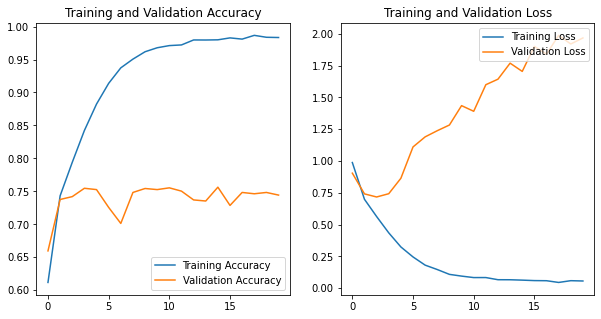

In [ ]:
acc = CNNhistory1.history['accuracy']
val_acc = CNNhistory1.history['val_accuracy']

loss = CNNhistory1.history['loss']
val_loss = CNNhistory1.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see that this is overfitting.

# Results

#### In the whole code I have tried to bring out accuracy of my model trying to achieve maximum accuracy. 